In [1]:
from common import colors

In [2]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..', '..'))
print os.getcwd()

/Users/eharkin/Documents/projects/5HTGIF


In [3]:
import warnings
import re

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns
import numpy as np
from sklearn.model_selection import ParameterGrid
from scipy import stats

from ezephys import pltools
from statannot import add_stat_annotation

from grr.Simulation import GIFnet_Simulation
from grr.GainEstimator import GainEstimator
from grr.Tools import raiseExpectedGot, timeToIndex, reprint
from grr.Spiketrain import PSTH
from grr.CurveFit import plot_linear_fit

In [5]:
plt.style.use(os.path.join('figs', 'scripts', 'writeup', 'publication_figure_style.dms'))
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'GIF_network')

In [6]:
def infer_gaba_condition(dir_name):
    regex_match = re.search(r'GABA_(.*)', dir_name)
    if regex_match is not None:
        condition = regex_match.groups()[-1]
    elif 'endocannabinoid' == dir_name:
        condition = 'endocannabinoid'
    else:
        raise ValueError('Unrecognized GABA condition {}'.format(dir_name))
    return condition

In [7]:
DATA_PATH = os.path.join('data', 'simulations', 'GIF_network', 'step_input')

sim_dict = {'Circuit': [], 'Mod type': [], 'Condition': [], 'Rep': [], 'Model': []}

network_models = [
    'DRN_homogenous_GABA_only',
    'DRN_homogenous_adaptation_swap',
    'DRN_homogenous_base',
    'DRN_subsample_adaptation_swap',
    'DRN_subsample_base',
    'DRN_subsample_fixedIA',
    'DRN_subsample_noIA',
    'mPFC_base'
]

for network_model in network_models:
    for gaba_condition in os.listdir(os.path.join(DATA_PATH, network_model)):
        for fname in os.listdir(os.path.join(DATA_PATH, network_model, gaba_condition)):
            if fname.endswith(('hdf5', 'h5')):

                sim_dict['Circuit'].append(
                    re.search(r'(DRN|mPFC)_(.*)', network_model).groups()[-2]
                )
                sim_dict['Mod type'].append(
                    re.search(r'(DRN|mPFC)_(.*)', network_model).groups()[-1]
                )
                sim_dict['Condition'].append(infer_gaba_condition(gaba_condition))
                sim_dict['Rep'].append(
                    int(re.search(r'rep([0-9]+)', fname).groups()[-1])
                )
                sim_dict['Model'].append(
                    GIFnet_Simulation(
                        os.path.join(DATA_PATH, network_model, gaba_condition, fname), 
                        mode = 'r'
                    )
                )

sim_df = pd.DataFrame(sim_dict).sort_values(['Mod type', 'Condition', 'Rep'])
sim_df.reset_index(inplace=True, drop=True)
sim_df.head()

,Circuit,Condition,Mod type,Model,Rep
0,mPFC,KO,base,[ser],0
1,mPFC,KO,base,[ser],1
2,mPFC,KO,base,[ser],2
3,mPFC,KO,base,[ser],3
4,mPFC,KO,base,[ser],4


In [8]:
sim_df['Principal PSTH'] = None
sim_df['Principal PSTH'] = sim_df['Principal PSTH'].astype(object)
sim_df['GABA PSTH'] = None
sim_df['GABA PSTH'] = sim_df['GABA PSTH'].astype(object)

In [9]:
PSTH_width = 50.

for i in range(sim_df.shape[0]):
    reprint('Computing PSTH {:.1f}%'.format(100. * i / sim_df.shape[0]))
    
    # Get PSTH from 5HT population.
    sim_df.at[i, 'Principal PSTH'] = np.empty((
        sim_df.loc[i, 'Model'].get_no_sweeps(), 
        sim_df.loc[i, 'Model'].get_no_timesteps()
    ))
    for sweep_no in range(sim_df.loc[i, 'Model'].get_no_sweeps()):
        sim_df.loc[i, 'Principal PSTH'][sweep_no, :] = PSTH(
            sim_df.loc[i, 'Model'].ser_spktrains[sweep_no, ...].sum(axis = 0),
            PSTH_width,
            sim_df.loc[i, 'Model'].get_no_ser_neurons()
        )
    
    # Get PSTHs from GABA population.
    if sim_df.loc[i, 'Condition'] != 'KO':
        sim_df.at[i, 'GABA PSTH'] = np.empty((
            sim_df.loc[i, 'Model'].get_no_sweeps(), 
            sim_df.loc[i, 'Model'].get_no_timesteps()
        ))
        for sweep_no in range(sim_df.loc[i, 'Model'].get_no_sweeps()):
            sim_df.loc[i, 'GABA PSTH'][sweep_no, :] = PSTH(
                sim_df.loc[i, 'Model'].gaba_spktrains[sweep_no, ...].sum(axis = 0),
                PSTH_width,
                sim_df.loc[i, 'Model'].get_no_gaba_neurons()
            )
    else:
        sim_df.loc[i, 'GABA PSTH'] = None
        continue

print('\nDone!')

Computing PSTH 99.8%
Done!


In [10]:
psth_dict = {'Circuit': [], 'Mod type': [], 'Condition': [], 'Principal PSTH': [], 'GABA PSTH': []}
for circuit in sim_df['Circuit'].unique():
    for modtype in sim_df.loc[sim_df['Circuit'] == circuit, 'Mod type'].unique():
        for cond in sim_df.loc[(sim_df['Circuit'] == circuit) & (sim_df['Mod type'] == modtype), 'Condition'].unique():
            psth_dict['Circuit'].append(circuit)
            psth_dict['Mod type'].append(modtype)
            psth_dict['Condition'].append(cond)
            psth_dict['Principal PSTH'].append(np.array(
                sim_df.loc[(sim_df['Circuit'] == circuit) & (sim_df['Condition'] == cond) & (sim_df['Mod type'] == modtype), 'Principal PSTH'].tolist()
            ))
            psth_dict['GABA PSTH'].append(np.array(
                sim_df.loc[(sim_df['Circuit'] == circuit) & (sim_df['Condition'] == cond) & (sim_df['Mod type'] == modtype), 'GABA PSTH'].tolist()
            ))
psth_df = pd.DataFrame(psth_dict)
del psth_dict

In [11]:
psth_df.head()

,Circuit,Condition,GABA PSTH,Mod type,Principal PSTH
0,mPFC,KO,"[None, None, None, None, None, None, None, Non...",base,"[[[1.1333333333333335, 1.1333333333333335, 1.1..."
1,DRN,KO,"[None, None, None, None, None, None, None, Non...",homogenous_GABA_only,"[[[0.06666666666666667, 0.06666666666666667, 0..."
2,DRN,base,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",homogenous_GABA_only,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,DRN,endocannabinoid,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",homogenous_GABA_only,"[[[0.03333333333333333, 0.03333333333333333, 0..."
4,DRN,KO,"[None, None, None, None, None, None, None, Non...",homogenous_adaptation_swap,"[[[0.06666666666666667, 0.06666666666666667, 0..."


In [12]:
def select_PSTH_dataset(dframe, circuit, condition, mod_type, psth_type='Principal PSTH'):
    return dframe.loc[
        (dframe['Circuit'] == circuit)
        & (dframe['Condition'] == condition) 
        & (dframe['Mod type'] == mod_type), 
        psth_type
    ].item()

In [13]:
def get_step_amplitudes(simulation, step_start_time):
    step_start_ind = timeToIndex(step_start_time, 0.1)[0]
    baseline = simulation['ser/examples/I'][..., :step_start_ind].mean()
    return simulation['ser/examples/I'][..., step_start_ind:].mean(axis=2).mean(axis=1) - baseline

def get_pointwise_gain(psth_arr, step_amplitudes, baseline_start_time, step_start_time, cov=False, dt=0.1):
    """
    Returns
    -------
    (gain, intercept) if cov = False, or (gain, intercept, parameter_covariance_matrix) if cov=True.
    
    """
    assert np.ndim(psth_arr) == 3
    assert np.ndim(step_amplitudes) == 1
    assert np.shape(psth_arr)[1] == len(step_amplitudes)
    
    step_start_ind = timeToIndex(step_start_time, dt)[0]
    step_response = psth_arr[..., step_start_ind:]
    mean_step_response = step_response.mean(axis=0)
    
    baseline_activity = psth_arr[..., timeToIndex(baseline_start_time, dt)[0]:step_start_ind]
    mean_baseline_activity = baseline_activity.mean(axis=0).mean(axis=1)  # Average over sweeps and time.
    assert np.ndim(mean_baseline_activity) == 1
    assert len(mean_baseline_activity) == mean_step_response.shape[0]
    
    coeffs, V = np.polyfit(step_amplitudes, mean_step_response - mean_baseline_activity[:, np.newaxis], deg=1, cov=cov)
    
    if cov:
        return coeffs[0, :], coeffs[1, :], V
    else:
        return coeffs[0, :], coeffs[1, :]

In [14]:
step_amplitudes = get_step_amplitudes(sim_df.loc[0, 'Model'], 1000.)

In [15]:
def plot_lines_cmap(x, y, cmap, start=0., stop=1., ax=None, **pltargs):
    if ax is None:
        ax = plt.gca()
    
    colors = cmap(np.linspace(start, stop, np.shape(y)[1]))
    for i in range(np.shape(y)[1]):
        ax.plot(x, y[:, i], color=colors[i], **pltargs)

In [16]:
class GainSimulationVisualizer(object):
    def __init__(
        self,
        psth_dataframe,
        step_amplitudes,
        baseline_interval,
        stimulus_interval,
        dt=0.1,
    ):
        """Initialize GainSimulationVisualizer.

        Arguments
        ---------
        psth_dataframe : pandas.DataFrame
        step_amplitudes : 1D float array
        baseline_interval, stimulus_interval : pair of floats
            Time window to extract baseline/stimulus (ms).
        dt : float, default 0.1
            Time step (ms).

        """
        self.psth_dataframe = psth_dataframe
        self.step_amplitudes = step_amplitudes
        self.baseline_interval = baseline_interval
        self.stimulus_interval = stimulus_interval
        self.dt = dt

    def plot_gain(
        self, circuit, condition, mod_type, psth_type, ax=None, label=None, **pltargs
    ):
        """Plot gain over time.

        Wraps select_PSTH_dataset.

        """
        if ax is None:
            ax = plt.gca()

        gain_estimator = self._fit_gain_estimator(
            circuit, condition, mod_type, psth_type
        )

        ax.fill_between(
            self._get_time_support(),
            gain_estimator.gain - gain_estimator.gainUncertainty,
            gain_estimator.gain + gain_estimator.gainUncertainty,
            alpha=0.7,
            lw=0,
            **pltargs
        )
        ax.plot(self._get_time_support(), gain_estimator.gain, label=label, **pltargs)

    def plot_intercept(
        self, circuit, condition, mod_type, psth_type, ax=None, label=None, **pltargs
    ):
        """Plot intercept over time.

        Wraps select_PSTH_dataset.

        """
        if ax is None:
            ax = plt.gca()

        gain_estimator = self._fit_gain_estimator(
            circuit, condition, mod_type, psth_type
        )

        ax.fill_between(
            self._get_time_support(),
            gain_estimator.intercept - gain_estimator.interceptUncertainty,
            gain_estimator.intercept + gain_estimator.interceptUncertainty,
            alpha=0.7,
            lw=0,
            **pltargs
        )
        ax.plot(self._get_time_support(), gain_estimator.intercept, label=label, **pltargs)

    def _fit_gain_estimator(self, circuit, condition, mod_type, psth_type):
        dset = select_PSTH_dataset(
            self.psth_dataframe, circuit, condition, mod_type, psth_type
        )
        gain_estimator = GainEstimator(self.dt)
        gain_estimator.fit(
            dset,
            self.step_amplitudes,
            self.baseline_interval,
            self.stimulus_interval,
        )
        return gain_estimator
    
    def plot_psth(self, circuit, condition, mod_type, psth_type, sweeps, cmap, ax=None, label=None, **pltargs):
        dset = select_PSTH_dataset(
            self.psth_dataframe, circuit, condition, mod_type, psth_type
        )
        psth_mean = dset[..., self._get_stimulus_slice()].mean(axis=0)
        psth_std = dset[..., self._get_stimulus_slice()].std(axis=0)
        
        if ax is None:
            ax = plt.gca()
        
        colors = cmap(np.linspace(0.3, 1., psth_mean.shape[0]))
        labeled_flag = False
        for i in sweeps:
            ax.fill_between(
                self._get_time_support(), 
                psth_mean[i, :] - psth_std[i, :], 
                psth_mean[i, :] + psth_std[i, :], 
                color=colors[i], 
                alpha=0.7,
                lw=0,
                **pltargs
            )
            if not labeled_flag:
                ax.plot(self._get_time_support(), psth_mean[i, :], color=colors[i], label=label, **pltargs)
                labeled_flag = True
            else:
                ax.plot(self._get_time_support(), psth_mean[i, :], color=colors[i], **pltargs)
    
    def _get_stimulus_slice(self):
        return slice(*timeToIndex(self.stimulus_interval, self.dt))

    def _get_time_support(self):
        return np.arange(
            0.0,
            (self.stimulus_interval[1] - self.stimulus_interval[0])
            - 0.5 * self.dt,
            self.dt,
        )

In [17]:
visualizer = GainSimulationVisualizer(psth_df, step_amplitudes, (800., 900.), (1000., 1900.))

# Publication figures
## Interpretation of network output

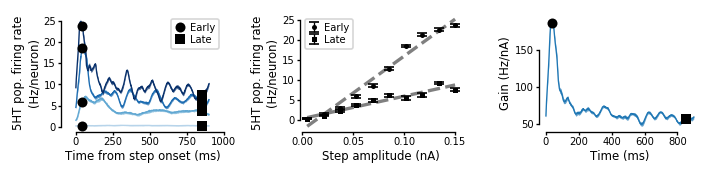

In [51]:
ser_ctrl_psth = select_PSTH_dataset(psth_df, 'DRN', 'KO', 'subsample_base', 'Principal PSTH')

ebar_params = {'ls': 'none', 'capsize': 3, 'ecolor': 'k', 'markersize': 3}
markeredgecolor='none'
cmap = plt.get_cmap('Blues')
stim_start_time = 1000.
peak_ind = 10400
steady_ind = 18500
t_vec = sim_df['Model'][0].get_t_vec() - stim_start_time

spec = gs.GridSpec(1, 3)

plt.figure(figsize=(6, 1.5))

plt.subplot(spec[:, 0])
visualizer.plot_psth('DRN', 'KO', 'subsample_base', 'Principal PSTH', range(0, 10, 3), cmap)
#plot_lines_cmap(t_vec, ser_ctrl_psth[0, ::3, :].T, cmap, start=0.1)
plt.plot(
    [peak_ind * 0.1 - stim_start_time] * 4, 
    ser_ctrl_psth[:, ::3, peak_ind].mean(axis=0), 
    'ko', label='Early', markeredgecolor=markeredgecolor
)
plt.plot(
    [steady_ind * 0.1 - stim_start_time] * 4, 
    ser_ctrl_psth[:, ::3, steady_ind].mean(axis=0), 
    'ks', label='Late', markeredgecolor=markeredgecolor
)
plt.xlim(-100., 1000.)
plt.xlabel('Time from step onset (ms)')
plt.ylabel('5HT pop. firing rate\n(Hz/neuron)')
plt.legend(markerscale=1)

plt.subplot(spec[:, 1])
plt.errorbar(
    marker='o',
    color='k',
    markeredgecolor=markeredgecolor,
    x=step_amplitudes,
    y=ser_ctrl_psth[..., peak_ind].mean(axis=0), 
    yerr=ser_ctrl_psth[..., peak_ind].std(axis=0),
    label='Early',
    **ebar_params
)
plt.errorbar(
    marker='s',
    color='k',
    markeredgecolor=markeredgecolor,
    x=step_amplitudes,
    y=ser_ctrl_psth[..., steady_ind].mean(axis=0), 
    yerr=ser_ctrl_psth[..., steady_ind].std(axis=0),
    label='Late',
    **ebar_params
)
plot_linear_fit(step_amplitudes, ser_ctrl_psth[..., peak_ind].mean(axis=0), zorder=-1, lw=2, ls='--', color='gray')
plot_linear_fit(step_amplitudes, ser_ctrl_psth[..., steady_ind].mean(axis=0), zorder=-1, lw=2, ls='--', color='gray')
plt.ylabel('5HT pop. firing rate\n(Hz/neuron)')
plt.xlabel('Step amplitude (nA)')
plt.legend(markerscale=1)

plt.subplot(spec[:, 2])
visualizer.plot_gain('DRN', 'KO', 'subsample_base', 'Principal PSTH', color=colors['ser'])

ser_gain = GainEstimator(0.1)
ser_gain.fit(select_PSTH_dataset(psth_df, 'DRN', 'KO', 'subsample_base', 'Principal PSTH'), step_amplitudes, (800., 900.), (1000., 1900.))

plt.plot(
    [peak_ind * 0.1 - stim_start_time], 
    [ser_gain.gain[peak_ind - timeToIndex(stim_start_time, 0.1)[0]] ],
    'ko',
    markeredgecolor=markeredgecolor
)
plt.plot(
    [steady_ind * 0.1 - stim_start_time], 
    [ser_gain.gain[steady_ind - timeToIndex(stim_start_time, 0.1)[0]]],
    'ks',
    markeredgecolor=markeredgecolor
)
plt.ylabel('Gain (Hz/nA)')
plt.xlabel('Time (ms)')

sns.despine(trim=True)

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'control_gain_illustration.png'))

del ser_ctrl_psth, ser_gain

## Effect of IA in network with GABA

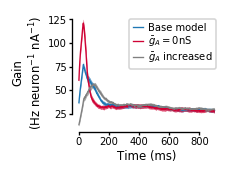

In [20]:
plt.figure(figsize=(2, 1.5))

plt.subplot(111)
visualizer.plot_gain('DRN', 'base', 'subsample_base', 'Principal PSTH', color=colors['ser'], label='Base model')
visualizer.plot_gain('DRN', 'base', 'subsample_noIA', 'Principal PSTH', color=colors['4AP'], label=r'$\bar{g}_A = 0$nS')
visualizer.plot_gain('DRN', 'base', 'subsample_fixedIA', 'Principal PSTH', color='gray', label=r'$\bar{g}_A$ increased')
plt.xlabel('Time (ms)')
plt.ylabel('Gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'IA_gain_illustration.png'))

In [21]:
def get_gain_peak(circuit, condition, mod_type, psth_type):
    gain = visualizer._fit_gain_estimator(circuit, condition, mod_type, psth_type).gainByRep
    return gain.max(axis=1)

def get_gain_ss(circuit, condition, mod_type, psth_type):
    gain = visualizer._fit_gain_estimator(circuit, condition, mod_type, psth_type).gainByRep
    return gain[:, -1000:].mean(axis=1)

def get_gain_ratio(circuit, condition, mod_type, psth_type):
    return get_gain_peak(circuit, condition, mod_type, psth_type) / get_gain_ss(circuit, condition, mod_type, psth_type)

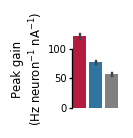

In [22]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
ax = sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        'Base model': get_gain_peak('DRN', 'base', 'subsample_base', 'Principal PSTH'),
        r'$\bar{g}_A = 0$nS': get_gain_peak('DRN', 'base', 'subsample_noIA', 'Principal PSTH'),
        r'$\bar{g}_A$ increased': get_gain_peak('DRN', 'base', 'subsample_fixedIA', 'Principal PSTH')
    }).melt(),
    order=[r'$\bar{g}_A = 0$nS', 'Base model', r'$\bar{g}_A$ increased'],
    palette = [colors['4AP'], colors['ser'], 'gray'],
    ci='sd'
)
plt.ylabel('Peak gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')
gain_barplot_ylim = plt.ylim()

pltools.hide_border('trb', trim=True)

plt.subplots_adjust(left=0.55, bottom=0.2, top=0.85, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'IA_and_peak_gain.png'))

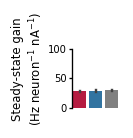

In [23]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        'Base model': get_gain_ss('DRN', 'base', 'subsample_base', 'Principal PSTH'),
        r'$\bar{g}_A = 0$nS': get_gain_ss('DRN', 'base', 'subsample_noIA', 'Principal PSTH'),
        r'$\bar{g}_A$ increased': get_gain_ss('DRN', 'base', 'subsample_fixedIA', 'Principal PSTH')
    }).melt(),
    order=[r'$\bar{g}_A = 0$nS', 'Base model', r'$\bar{g}_A$ increased'],
    palette = [colors['4AP'], colors['ser'], 'gray'],
    ci='sd'
)
plt.ylabel('Steady-state gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')
plt.ylim(gain_barplot_ylim)

pltools.hide_border('trb', trim=True)

plt.subplots_adjust(left=0.55, bottom=0.2, top=0.85, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'IA_and_ss_gain.png'))

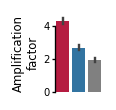

In [24]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        'Base model': get_gain_ratio('DRN', 'base', 'subsample_base', 'Principal PSTH'),
        r'$\bar{g}_A = 0$nS': get_gain_ratio('DRN', 'base', 'subsample_noIA', 'Principal PSTH'),
        r'$\bar{g}_A$ increased': get_gain_ratio('DRN', 'base', 'subsample_fixedIA', 'Principal PSTH')
    }).melt(),
    order=[r'$\bar{g}_A = 0$nS', 'Base model', r'$\bar{g}_A$ increased'],
    palette = [colors['4AP'], colors['ser'], 'gray'],
    ci='sd'
)
plt.ylabel('Amplification\nfactor')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')

pltools.hide_border('trb', trim=True)

plt.subplots_adjust(left=0.55, bottom=0.2, top=0.85, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'IA_and_gain_ratio.png'))

# Effect of GABA in network with IA

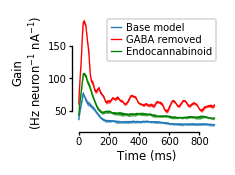

In [25]:
plt.figure(figsize=(2, 1.5))

plt.subplot(111)
visualizer.plot_gain('DRN', 'base', 'subsample_base', 'Principal PSTH', color=colors['ser'], label='Base model')
visualizer.plot_gain('DRN', 'KO', 'subsample_base', 'Principal PSTH', color='red', label=r'GABA removed')
visualizer.plot_gain('DRN', 'endocannabinoid', 'subsample_base', 'Principal PSTH', color='green', label=r'Endocannabinoid')
plt.xlabel('Time (ms)')
plt.ylabel('Gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'som_gain_illustration.png'))

Notice that knocking out GABA and simply removing their input have essentially the same effect on 5HT output.

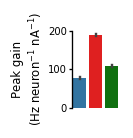

In [26]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        'Base model': get_gain_peak('DRN', 'base', 'subsample_base', 'Principal PSTH'),
        'GABA removed': get_gain_peak('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
        'Endocannabinoid': get_gain_peak('DRN', 'endocannabinoid', 'subsample_base', 'Principal PSTH')
    }).melt(),
    order=['Base model', 'GABA removed', 'Endocannabinoid'],
    palette = [colors['ser'], 'red', 'green'],
    ci='sd'
)
plt.ylabel('Peak gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')
gain_barplot_ylim = plt.ylim()

pltools.hide_border('trb', trim=True)

plt.subplots_adjust(left=0.55, bottom=0.2, top=0.85, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'som_and_peak_gain.png'))

In [27]:
stats.mannwhitneyu(
    get_gain_peak('DRN', 'base', 'subsample_base', 'Principal PSTH'), 
    get_gain_peak('DRN', 'endocannabinoid', 'subsample_base', 'Principal PSTH'),
    alternative='two-sided'
)

MannwhitneyuResult(statistic=0.0, pvalue=6.795615128173358e-08)

In [28]:
stats.mannwhitneyu(
    get_gain_peak('DRN', 'base', 'subsample_base', 'Principal PSTH'), 
    get_gain_peak('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
    alternative='two-sided'
)

MannwhitneyuResult(statistic=0.0, pvalue=6.795615128173358e-08)

In [29]:
stats.mannwhitneyu(
    get_gain_peak('DRN', 'endocannabinoid', 'subsample_base', 'Principal PSTH'), 
    get_gain_peak('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
    alternative='two-sided'
)

MannwhitneyuResult(statistic=0.0, pvalue=6.795615128173358e-08)

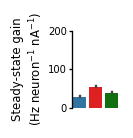

In [30]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        'Base model': get_gain_ss('DRN', 'base', 'subsample_base', 'Principal PSTH'),
        'GABA removed': get_gain_ss('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
        'Endocannabinoid': get_gain_ss('DRN', 'endocannabinoid', 'subsample_base', 'Principal PSTH')
    }).melt(),
    order=['Base model', 'GABA removed', 'Endocannabinoid'],
    palette = [colors['ser'], 'red', 'green'],
    ci='sd'
)
plt.ylabel('Steady-state gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')
plt.ylim(gain_barplot_ylim)

pltools.hide_border('trb', trim=True)

plt.subplots_adjust(left=0.55, bottom=0.2, top=0.85, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'som_and_ss_gain.png'))

In [31]:
stats.mannwhitneyu(
    get_gain_ss('DRN', 'base', 'subsample_base', 'Principal PSTH'), 
    get_gain_ss('DRN', 'endocannabinoid', 'subsample_base', 'Principal PSTH'),
    alternative='two-sided'
)

MannwhitneyuResult(statistic=0.0, pvalue=6.795615128173358e-08)

In [32]:
stats.mannwhitneyu(
    get_gain_ss('DRN', 'base', 'subsample_base', 'Principal PSTH'), 
    get_gain_ss('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
    alternative='two-sided'
)

MannwhitneyuResult(statistic=0.0, pvalue=6.795615128173358e-08)

In [33]:
stats.mannwhitneyu(
    get_gain_ss('DRN', 'endocannabinoid', 'subsample_base', 'Principal PSTH'), 
    get_gain_ss('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
    alternative='two-sided'
)

MannwhitneyuResult(statistic=0.0, pvalue=6.795615128173358e-08)

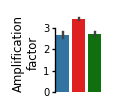

In [34]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        'Base model': get_gain_ratio('DRN', 'base', 'subsample_base', 'Principal PSTH'),
        'GABA removed': get_gain_ratio('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
        'Endocannabinoid': get_gain_ratio('DRN', 'endocannabinoid', 'subsample_base', 'Principal PSTH')
    }).melt(),
    order=['Base model', 'GABA removed', 'Endocannabinoid'],
    palette = [colors['ser'], 'red', 'green'],
    ci='sd'
)
plt.ylabel('Amplification\nfactor')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')

pltools.hide_border('trb', trim=True)

plt.subplots_adjust(left=0.55, bottom=0.2, top=0.85, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'som_and_gain_ratio.png'))

In [35]:
stats.mannwhitneyu(
    get_gain_ratio('DRN', 'base', 'subsample_base', 'Principal PSTH'), 
    get_gain_ratio('DRN', 'endocannabinoid', 'subsample_base', 'Principal PSTH'),
    alternative='two-sided'
)

MannwhitneyuResult(statistic=152.0, pvalue=0.19883449020829447)

In [36]:
stats.mannwhitneyu(
    get_gain_ratio('DRN', 'base', 'subsample_base', 'Principal PSTH'), 
    get_gain_ratio('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
    alternative='two-sided'
)

MannwhitneyuResult(statistic=0.0, pvalue=6.795615128173358e-08)

In [37]:
stats.mannwhitneyu(
    get_gain_ratio('DRN', 'endocannabinoid', 'subsample_base', 'Principal PSTH'), 
    get_gain_ratio('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
    alternative='two-sided'
)

MannwhitneyuResult(statistic=0.0, pvalue=6.795615128173358e-08)

## Cell type comparison

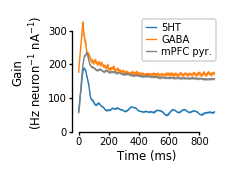

In [42]:
plt.figure(figsize=(2, 1.5))

plt.subplot(111)
visualizer.plot_gain('DRN', 'KO', 'subsample_base', 'Principal PSTH', color=colors['ser'], label='5HT')
visualizer.plot_gain('DRN', 'base', 'subsample_base', 'GABA PSTH', color=colors['som'], label='GABA')
visualizer.plot_gain('mPFC', 'KO', 'base', 'Principal PSTH', color=colors['pyr'], label='mPFC pyr.')
plt.ylim(0, plt.ylim()[1])
plt.xlabel('Time (ms)')
plt.ylabel('Gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'celltype_gain_illustration.png'))

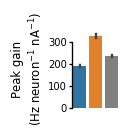

In [39]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        '5HT': get_gain_peak('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
        'GABA': get_gain_peak('DRN', 'base', 'subsample_base', 'GABA PSTH'),
        'mPFC pyr.': get_gain_peak('mPFC', 'KO', 'base', 'Principal PSTH')
    }).melt(),
    order=['5HT', 'GABA', 'mPFC pyr.'],
    palette = [colors['ser'], colors['som'], colors['pyr']],
    ci='sd'
)
plt.ylabel('Peak gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')
gain_barplot_ylim = plt.ylim()

pltools.hide_border('trb', trim=True)

plt.subplots_adjust(left=0.55, bottom=0.2, top=0.85, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'celltype_and_peak_gain.png'))

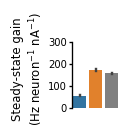

In [40]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        '5HT': get_gain_ss('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
        'GABA': get_gain_ss('DRN', 'base', 'subsample_base', 'GABA PSTH'),
        'mPFC pyr.': get_gain_ss('mPFC', 'KO', 'base', 'Principal PSTH')
    }).melt(),
    order=['5HT', 'GABA', 'mPFC pyr.'],
    palette = [colors['ser'], colors['som'], colors['pyr']],
    ci='sd'
)
plt.ylabel('Steady-state gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')
plt.ylim(gain_barplot_ylim)

pltools.hide_border('trb', trim=True)

plt.subplots_adjust(left=0.55, bottom=0.2, top=0.85, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'celltype_and_ss_gain.png'))

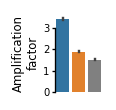

In [41]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        '5HT': get_gain_ratio('DRN', 'KO', 'subsample_base', 'Principal PSTH'),
        'GABA': get_gain_ratio('DRN', 'base', 'subsample_base', 'GABA PSTH'),
        'mPFC pyr.': get_gain_ratio('mPFC', 'KO', 'base', 'Principal PSTH')
    }).melt(),
    order=['5HT', 'GABA', 'mPFC pyr.'],
    palette = [colors['ser'], colors['som'], colors['pyr']],
    ci='sd'
)
plt.ylabel('Amplification\nfactor')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')

pltools.hide_border('trb', trim=True)

plt.subplots_adjust(left=0.55, bottom=0.2, top=0.85, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'celltype_and_gain_ratio.png'))

## Adaptation effect

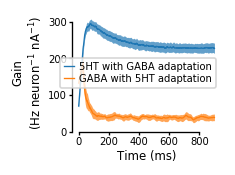

In [45]:
plt.figure(figsize=(2, 1.5))

plt.subplot(111)
visualizer.plot_gain(
    'DRN', 
    'KO', 
    'subsample_adaptation_swap', 
    'Principal PSTH', 
    color=colors['ser'], 
    label='5HT with GABA adaptation'
)
visualizer.plot_gain(
    'DRN', 
    'base', 
    'subsample_adaptation_swap', 
    'GABA PSTH', 
    color=colors['som'], 
    label='GABA with 5HT adaptation'
)
plt.ylim(0, plt.ylim()[1])
plt.xlabel('Time (ms)')
plt.ylabel('Gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'swapped_adaptation.png'))
    plt.savefig(os.path.join(IMG_PATH, 'swapped_adaptation.svg'))

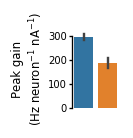

In [46]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        '5HT': get_gain_peak('DRN', 'KO', 'subsample_adaptation_swap', 'Principal PSTH'),
        'GABA': get_gain_peak('DRN', 'base', 'subsample_adaptation_swap', 'GABA PSTH')
    }).melt(),
    order=['5HT', 'GABA'],
    palette = [colors['ser'], colors['som']],
    ci='sd'
)
plt.ylabel('Peak gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')
gain_barplot_ylim = plt.ylim()

pltools.hide_border('trb', trim=True)

plt.subplots_adjust(left=0.55, bottom=0.2, top=0.85, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'adaptation_swap_and_peak_gain.png'))

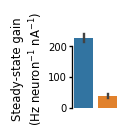

In [47]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        '5HT': get_gain_ss('DRN', 'KO', 'subsample_adaptation_swap', 'Principal PSTH'),
        'GABA': get_gain_ss('DRN', 'base', 'subsample_adaptation_swap', 'GABA PSTH')
    }).melt(),
    order=['5HT', 'GABA'],
    palette = [colors['ser'], colors['som']],
    ci='sd'
)
plt.ylabel('Steady-state gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')
gain_barplot_ylim = plt.ylim()

pltools.hide_border('trb', trim=True)

plt.subplots_adjust(left=0.55, bottom=0.2, top=0.85, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'adaptation_swap_and_ss_gain.png'))

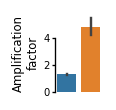

In [48]:
plt.figure(figsize=(1.0, 1))

plt.subplot(111)
sns.barplot(
    x='variable', 
    y='value', 
    data = pd.DataFrame({
        '5HT': get_gain_ratio('DRN', 'KO', 'subsample_adaptation_swap', 'Principal PSTH'),
        'GABA': get_gain_ratio('DRN', 'base', 'subsample_adaptation_swap', 'GABA PSTH')
    }).melt(),
    order=['5HT', 'GABA'],
    palette = [colors['ser'], colors['som']],
    ci='sd'
)
plt.ylabel('Amplification\nfactor')
plt.xlabel('')
plt.xticks([], rotation=45, ha='right')
gain_barplot_ylim = plt.ylim()

pltools.hide_border('trb', trim=True)

plt.subplots_adjust(left=0.55, bottom=0.2, top=0.85, right=0.95)

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'adaptation_swap_and_gain_ratio.png'))

## Homogeneity

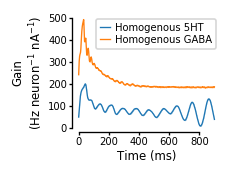

In [50]:
plt.figure(figsize=(2, 1.5))

plt.subplot(111)
visualizer.plot_gain(
    'DRN', 
    'KO', 
    'homogenous_base', 
    'Principal PSTH', 
    color=colors['ser'], 
    label='Homogenous 5HT'
)
visualizer.plot_gain(
    'DRN', 
    'base', 
    'homogenous_base', 
    'GABA PSTH', 
    color=colors['som'], 
    label='Homogenous GABA'
)
plt.xlabel('Time (ms)')
plt.ylabel('Gain\n(Hz neuron$^{-1}$ nA$^{-1}$)')
plt.legend()

sns.despine(trim=True)
plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'homogenous_populations.png'))
    plt.savefig(os.path.join(IMG_PATH, 'homogenous_populations.svg'))